# 6-9. 프로젝트: 자율주행 보조 시스템 만들기

<br/>

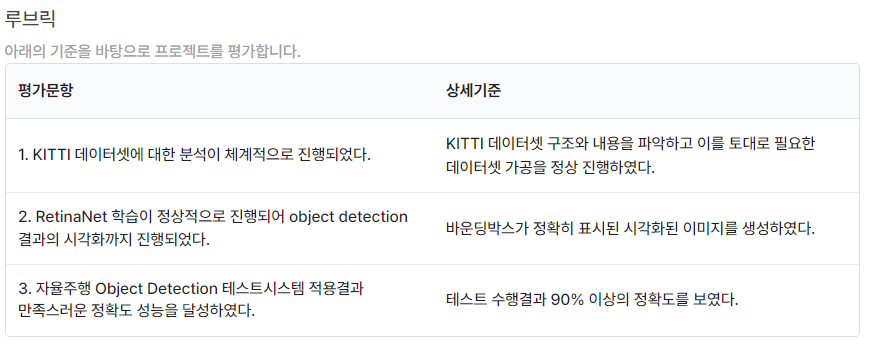

먼저 주요 라이브러리 버전을 확인해봅시다.

In [32]:
import tensorflow as tf

print(tf.__version__)

2.6.0


## 1. 자율주행 시스템 만들기
----
위에서 만든 모델을 통해 아래의 조건을 만족하는 함수를 만들어 주세요.

- 입력으로 이미지 경로를 받습니다.


- 정지조건에 맞는 경우 "Stop" 아닌 경우 "Go"를 반환합니다.


- 조건은 다음과 같습니다.


    - 사람이 한 명 이상 있는 경우
    - 차량의 크기(width or height)가 300px이상인 경우
    
```python    
img_path = os.getenv('HOME')+'/aiffel/object_detection/data/stop_1.png'

def self_drive_assist(img_path, size_limit=300):
    # 코드 구현
        # 정지조건에 맞으면 return "Stop"
        # 아닌 경우 return "Go"

print(self_drive_assist(img_path))
```

In [33]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/data/stop_1.png'

def self_drive_assist(img_path, size_limit=300):
    # 코드 구현
        # 정지조건에 맞으면 return "Stop"
        # 아닌 경우 return "Go"

print(self_drive_assist(img_path))

IndentationError: expected an indented block (3113234563.py, line 8)

## 2. 자율주행 시스템 평가하기
----
아래 test_system() 를 통해서 위에서 만든 함수를 평가해봅시다. 10장에 대해 Go와 Stop을 맞게 반환하는지 확인하고 100점 만점으로 평가해줍니다.

In [34]:
import os

def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection/data'
    score = 0
    test_set=[
        ("stop_1.png", "Stop"),
        ("stop_2.png", "Stop"),
        ("stop_3.png", "Stop"),
        ("stop_4.png", "Stop"),
        ("stop_5.png", "Stop"),
        ("go_1.png", "Go"),
        ("go_2.png", "Go"),
        ("go_3.png", "Go"),
        ("go_4.png", "Go"),
        ("go_5.png", "Go"),
    ]
    
    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

test_system(self_drive_assist)

NameError: name 'self_drive_assist' is not defined